# Spike detection and ffnn to predict parameters of the model
###### Has problems with python 3:
- Frame selection gets confused with the axes (function get_rec_list(k_file) in /mnt/cube/earneodo/repos/ephysflow/basic_viewing/structure/kwik_functions.py)

In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print( 'Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from swissknife.bci.core import expstruct as et

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf

from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp

from swissknife.decoder import linear as ld
from swissknife.decoder import neural as nd

import spike_detect_aux as aux
#from importlib import reload
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



print('All modules loaded')

Computer: passaro
All modules loaded


# Functions for collecting and manipulating frames of data

In [2]:
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

def spikes_array(chunk, thresholds, min_dist=10):
    #logger.info('Getting spikes from chunk with data sized {}'.format(chunk.data.shape))
    spk_lst = tp.find_spikes(chunk.data, thresholds, min_dist=min_dist)
    spk_arr = np.zeros_like(chunk.data)
    assert(len(spk_lst)==spk_arr.shape[1])
    for ch in range(len(spk_lst)):
        spk_arr[spk_lst[ch], ch] = 1
    return spk_arr

def collect_all_spk_arr(frames_list, thresholds, min_dist=10):
    return np.stack([spikes_array(fr, thresholds, min_dist=min_dist) for fr in frames_list], axis=0)

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

In [3]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [500, 10000]

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print(pattern_names)

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


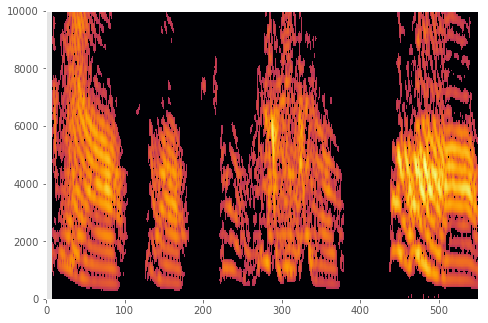

In [4]:
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide


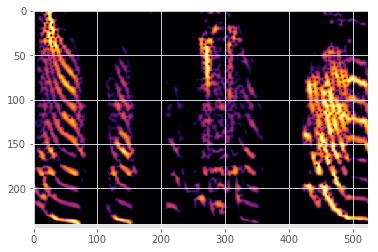

In [6]:
win_s = .001
win_samples = 128*8
step_s = .001
f_cut = 15000

#n_perseg = int(s_f * win_s)
n_perseg = win_samples

s_f = 30000
#n_overlap = int(s_f * (win_s - step_s))
n_overlap = win_samples - int(s_f*step_s)


#reload(sp)
f, t, s = sp.pretty_spectrogram(m_chunk.data[:,0], s_f, fft_size=n_perseg, log=True,
                      step_size=int(s_f*step_s), db_cut=65,
                     f_min=300, f_max=7500, window=('gaussian', 80))
plt.imshow(normalize((s))[::-1], aspect='auto', cmap='inferno')

In [7]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 29
#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float, chan_list=neural_chans)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, chan_list = h5d.chan_list, segment=[start-before, start + m_chunk.samples + after])
#lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot()

ValueError: axis(=-1) out of bounds

In [7]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

# WARNING, NEED A BETTER WAY TO GET THE RMS ACROSS A DAY OF RECORDINGS
logger.info('Done collecting frames')
rms = h5d.get_rms(window_size_samples=50000, n_windows=10000, rms_func=filter_rms, rms_args = (filter_pars,))

2017-05-11 19:41:05,338 root         INFO     Collecting 71 frames...
2017-05-11 19:41:05,340 root         INFO     Frame 0 ...
2017-05-11 19:41:05,978 root         INFO     Frame 10 ...
2017-05-11 19:41:06,419 root         INFO     Frame 20 ...
2017-05-11 19:41:07,004 root         INFO     Frame 30 ...
2017-05-11 19:41:07,544 root         INFO     Frame 40 ...
2017-05-11 19:41:08,716 root         INFO     Frame 50 ...
2017-05-11 19:41:09,272 root         INFO     Frame 60 ...
2017-05-11 19:41:09,754 root         INFO     Frame 70 ...
2017-05-11 19:41:09,821 root         INFO     Done collecting frames


2017-05-11 20:24:24,150 root         INFO     Collecting 71 frames...
2017-05-11 20:24:24,151 root         INFO     Frame 0 ...


[ 185.95984861  232.98819512  259.90328491  262.50529234  318.07886907
  258.0109575   322.07620389  277.44932758  268.44729312  239.28570468
  174.33128317  197.19379858  244.88818333  225.59454072  180.9833734
  246.38631016  239.67802944  319.444784    273.47886694  289.55231343
  299.83409028  308.17790588  240.85689739  272.51630518   94.44904587
  276.57660868  281.99693855  289.58581408  161.79476282  274.88749238
  279.7763375   289.2926509 ]


2017-05-11 20:24:24,615 root         INFO     Frame 10 ...
2017-05-11 20:24:25,021 root         INFO     Frame 20 ...
2017-05-11 20:24:25,391 root         INFO     Frame 30 ...
2017-05-11 20:24:25,606 root         INFO     Frame 40 ...
2017-05-11 20:24:25,718 root         INFO     Frame 50 ...
2017-05-11 20:24:25,941 root         INFO     Frame 60 ...
2017-05-11 20:24:26,083 root         INFO     Frame 70 ...


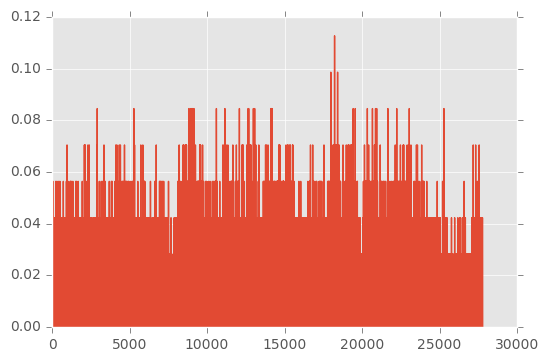

In [8]:
# Collect all the spikes (the support vector)

spike_thresh = 2.5
thresh = rms*spike_thresh
print(thresh)

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

[fr.apply_filter(sp.apply_butter_bandpass, filter_pars) for fr in all_frames]
all_spk_arr = collect_all_spk_arr(all_frames, thresh)
#all_spk_arr = np.stack(all_spk_lst, axis=0)
plt.plot(all_spk_arr.mean(axis=0)[:,0])

In [9]:
all_spk_arr.shape

(71, 27768, 32)

(<matplotlib.collections.PathCollection at 0x7fa2594f7ed0>,
 <matplotlib.axes._axes.Axes at 0x7fa26c7c0910>)

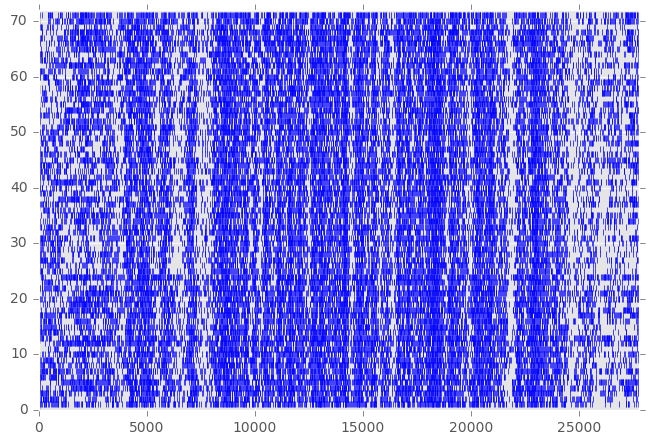

In [10]:
all_spk_arr.shape
bp.plot_raster(all_spk_arr[:,:,7])

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


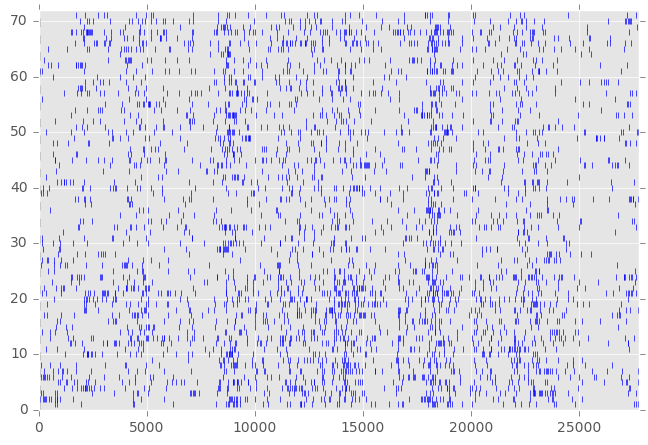

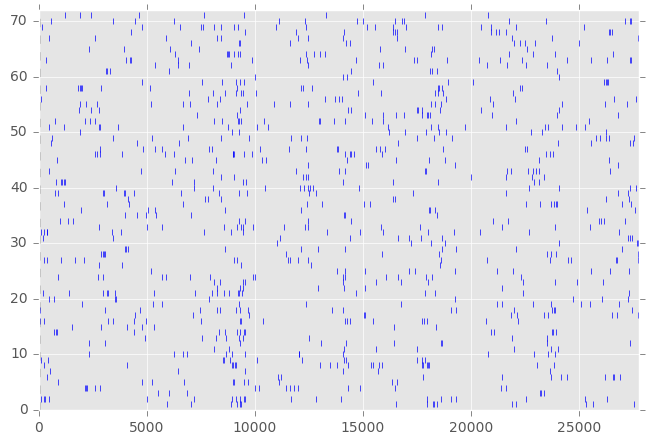

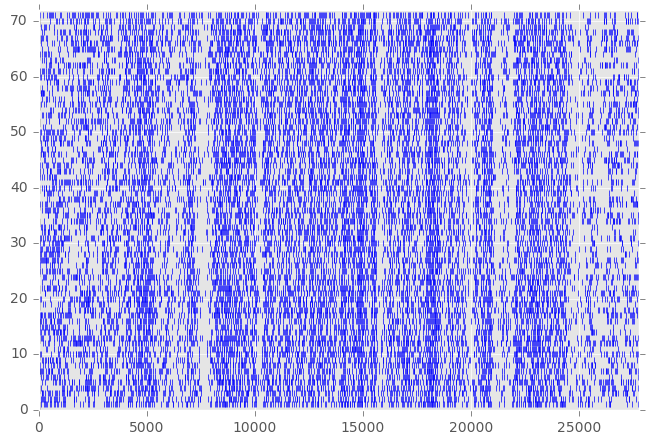

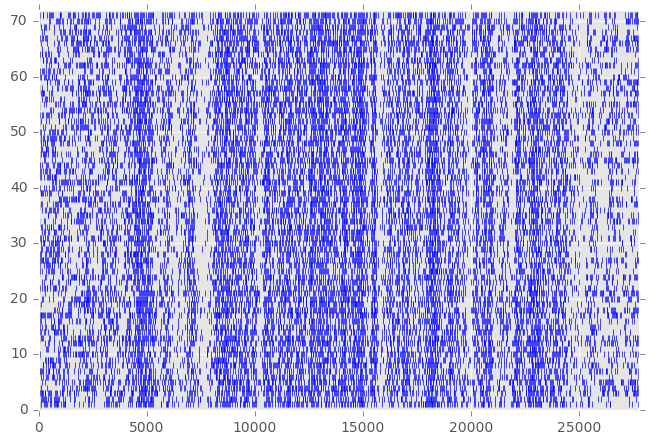

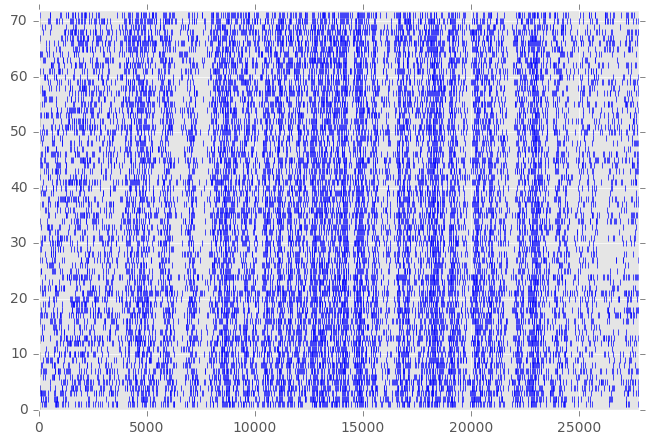

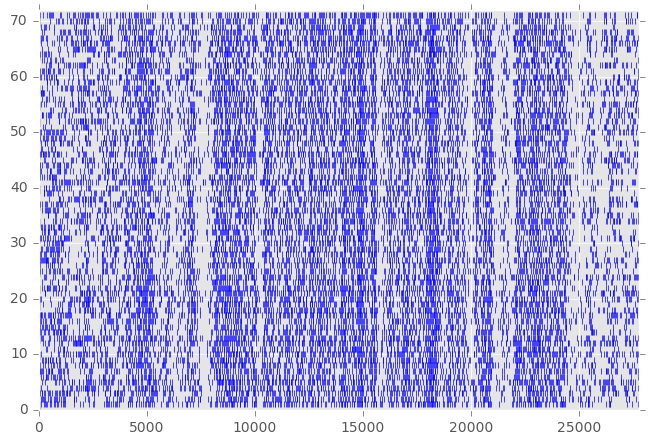

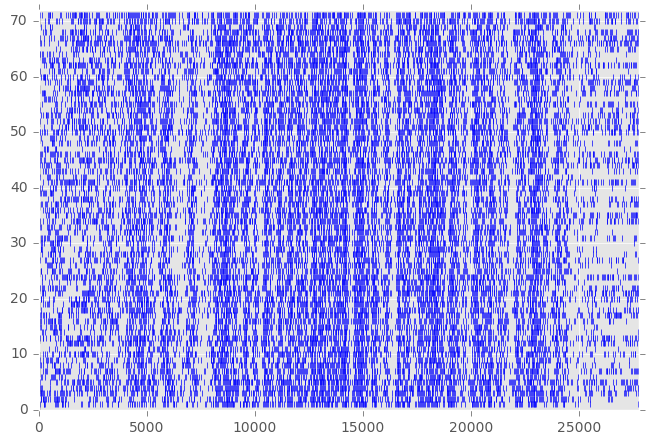

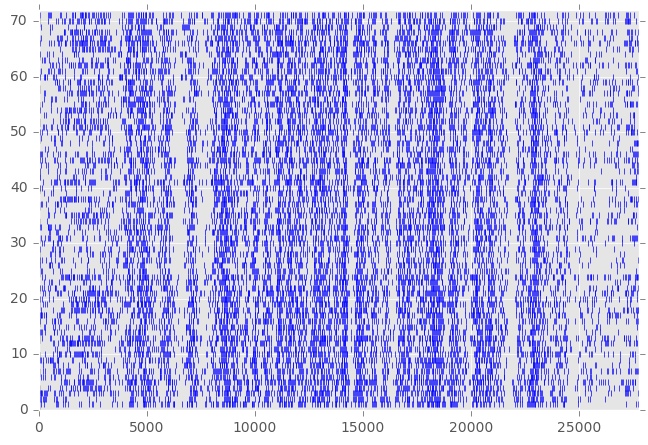

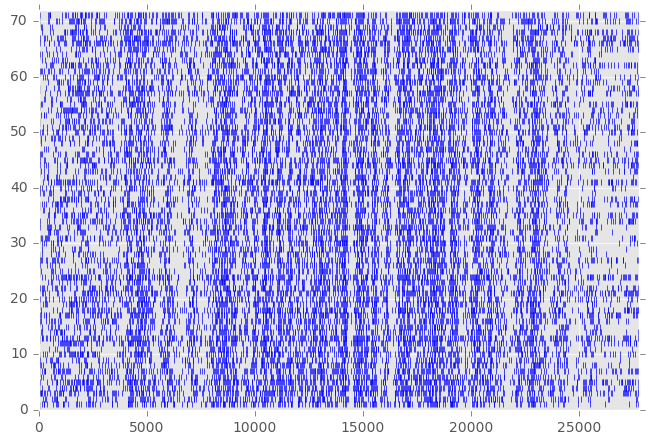

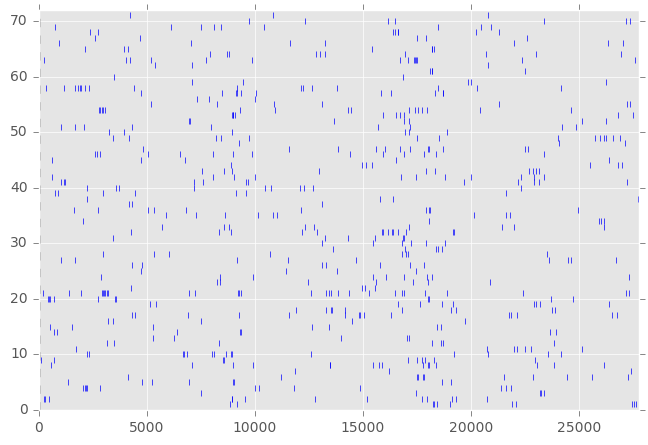

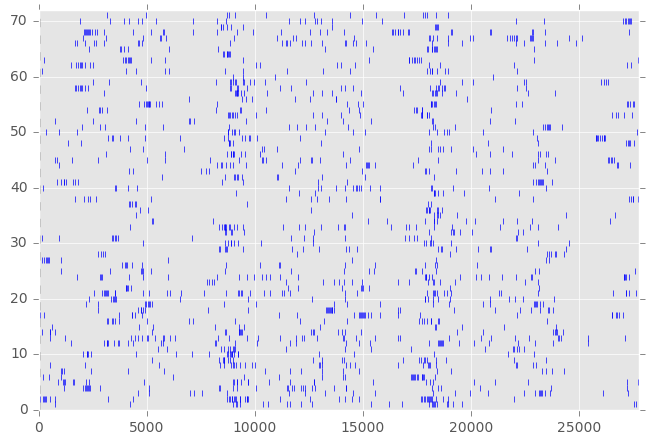

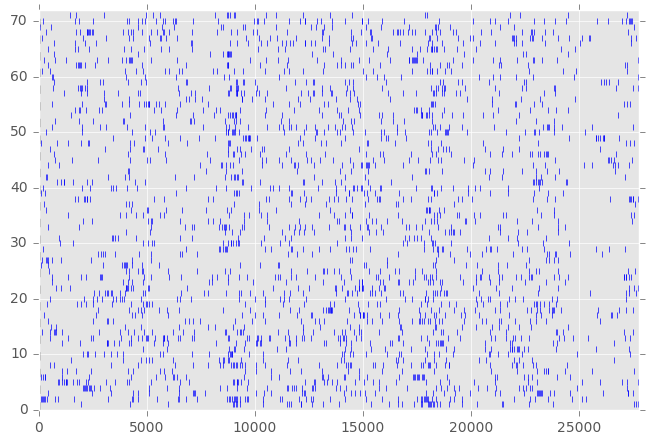

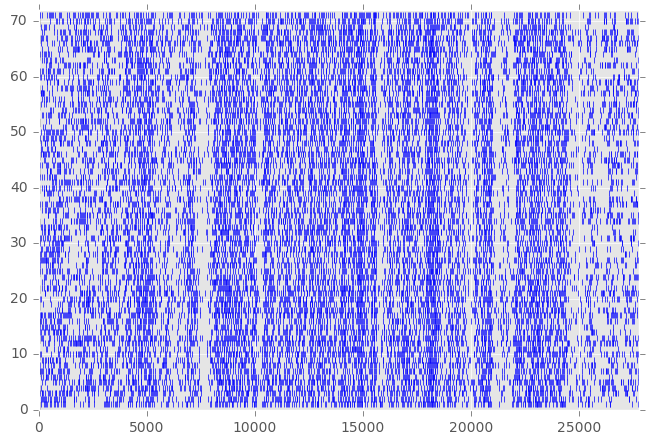

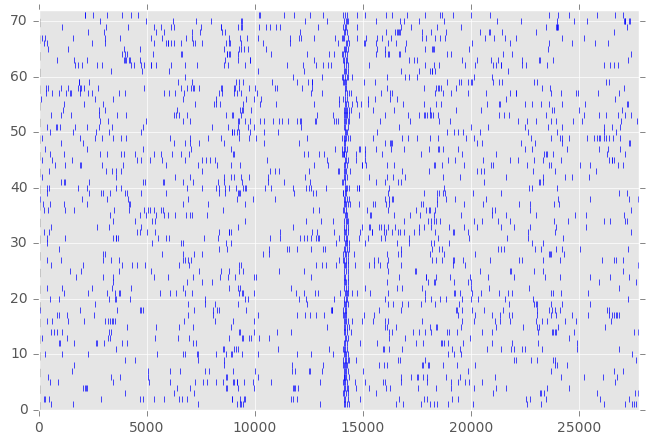

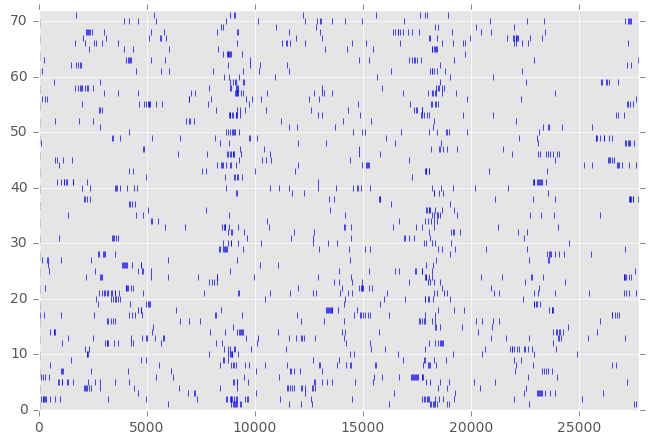

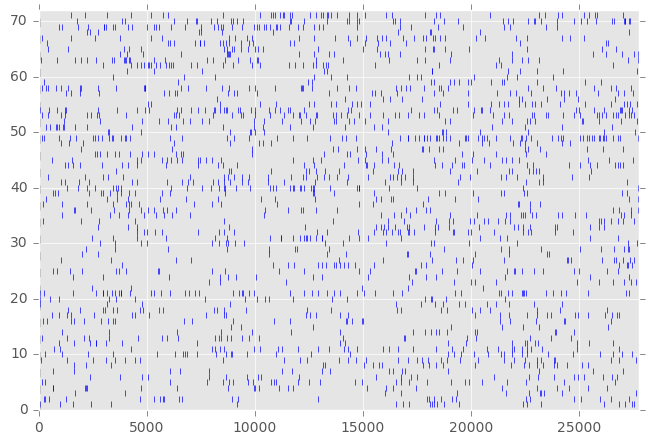

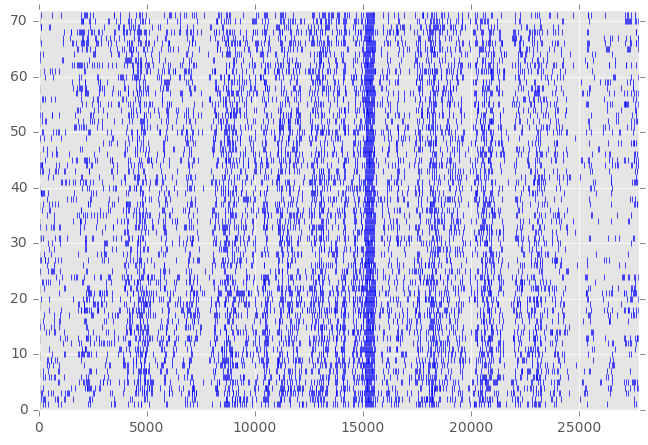

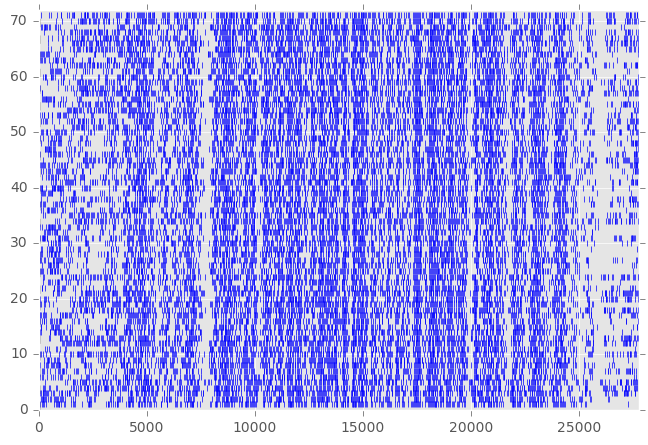

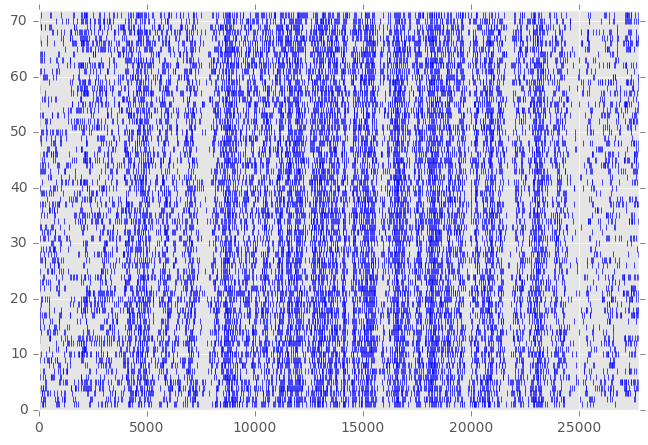

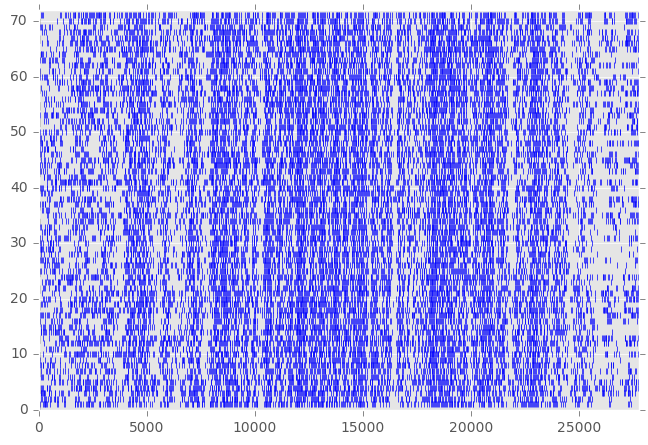

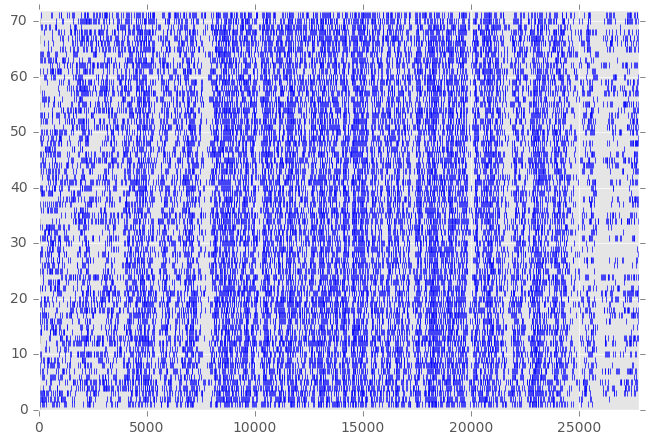

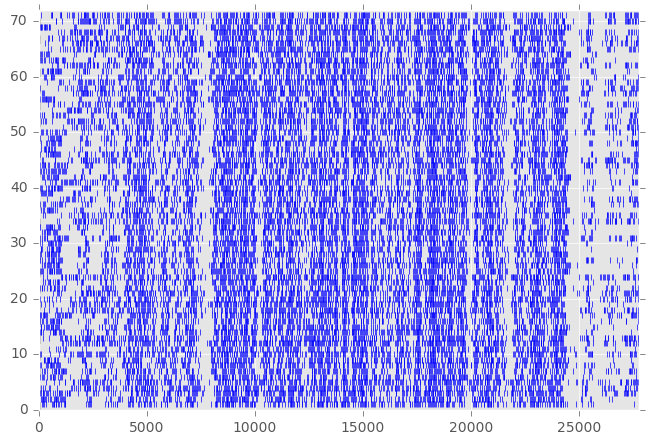

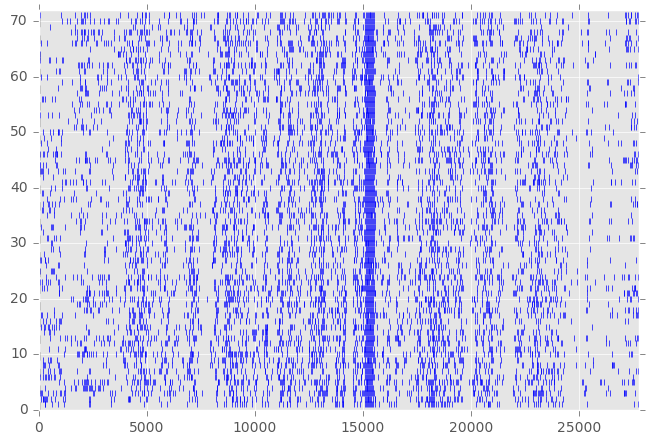

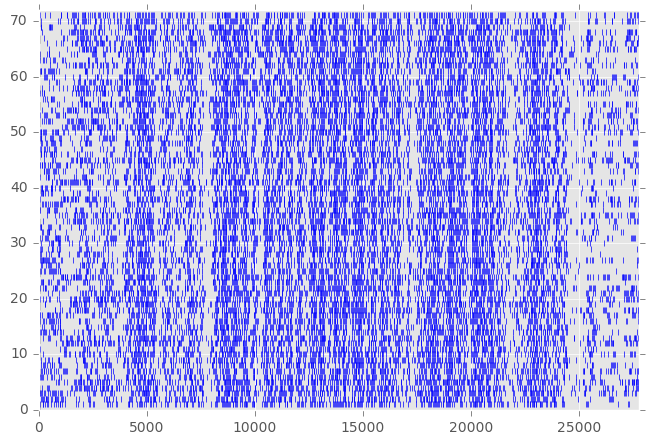

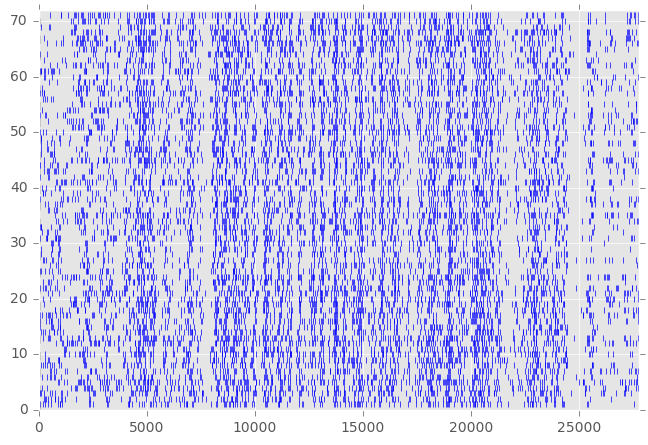

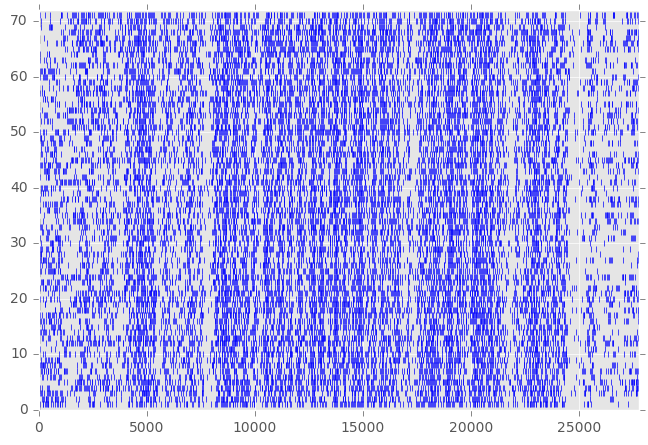

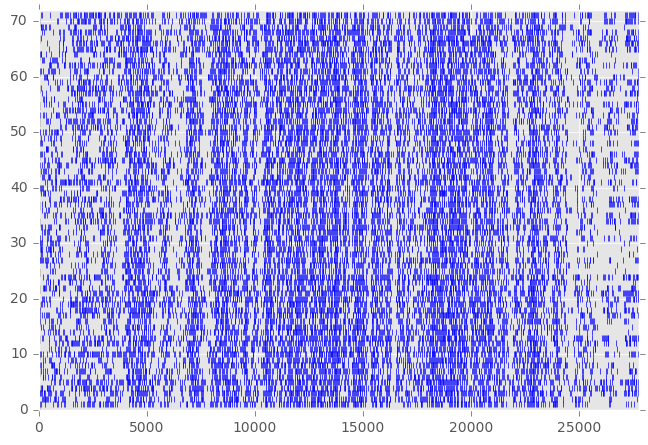

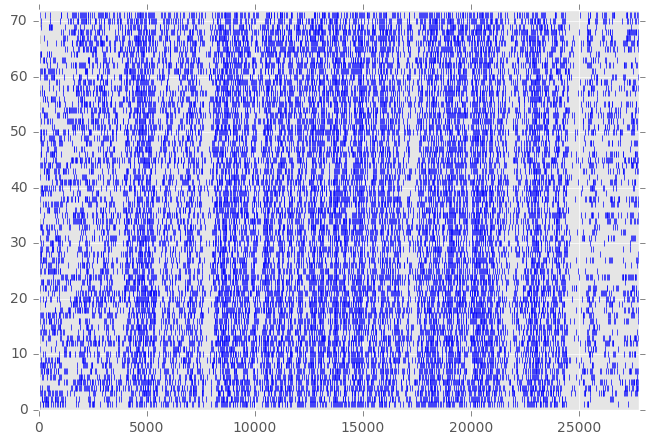

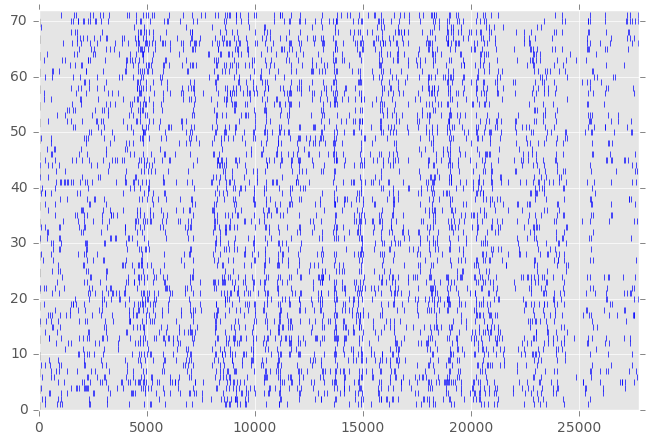

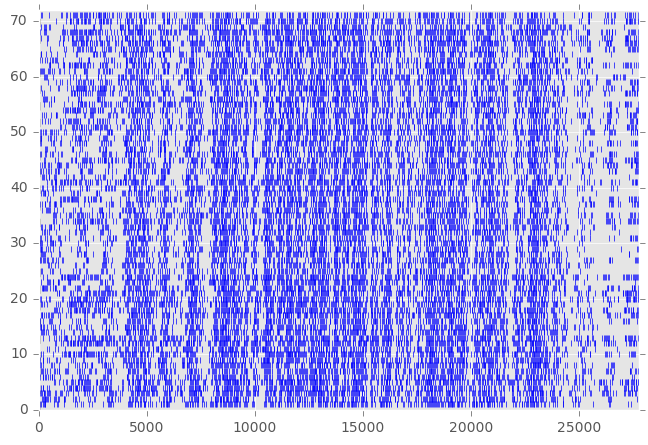

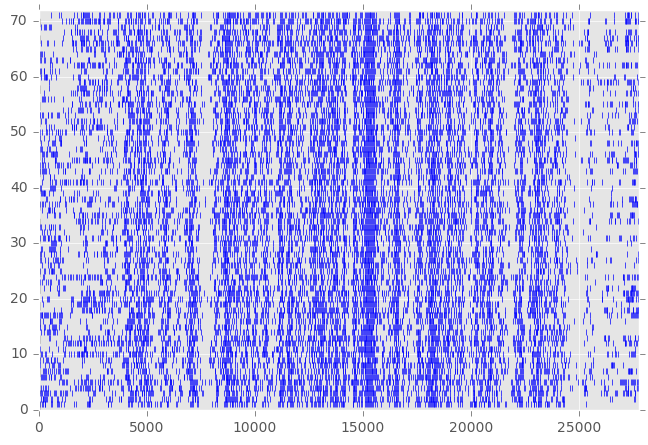

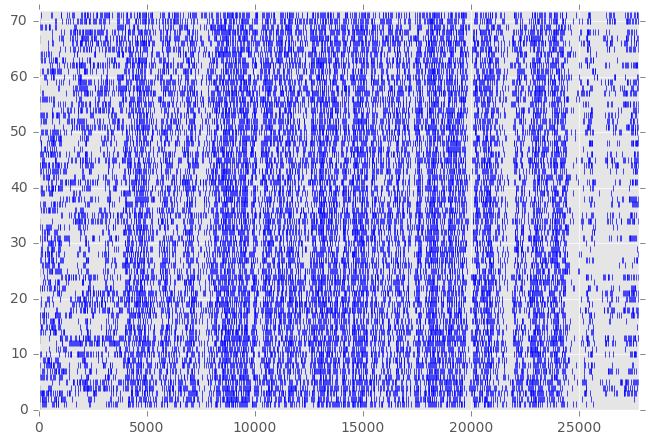

In [11]:
spike_thresh = 4.5
thresh = rms*spike_thresh
all_spk_arr = collect_all_spk_arr(all_frames, thresh, min_dist=20)
for i in range(neural_chans.size):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    bp.plot_raster(all_spk_arr[:,:,i])

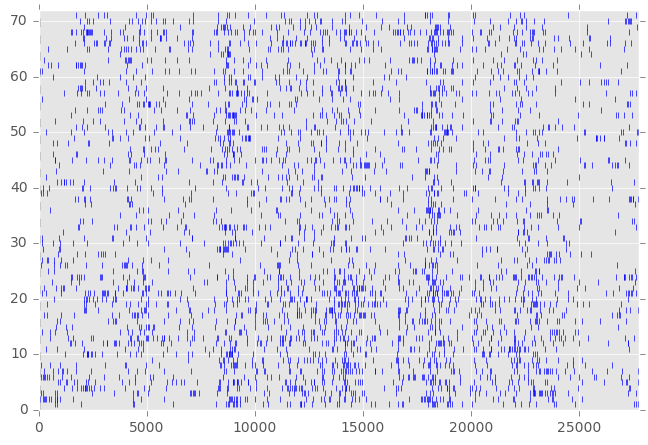

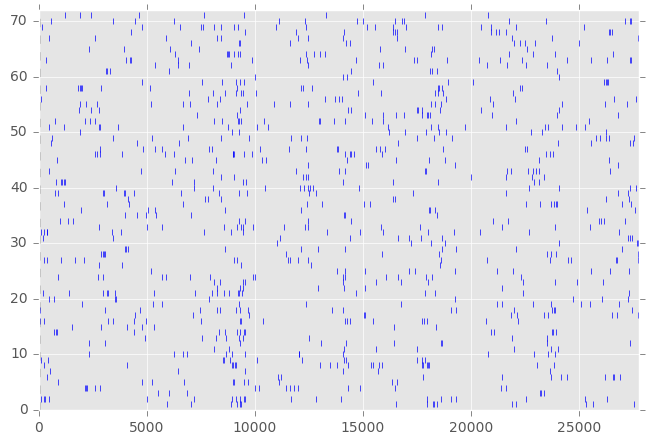

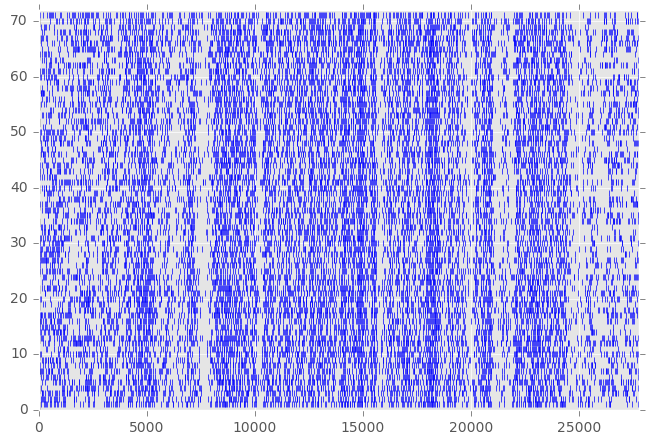

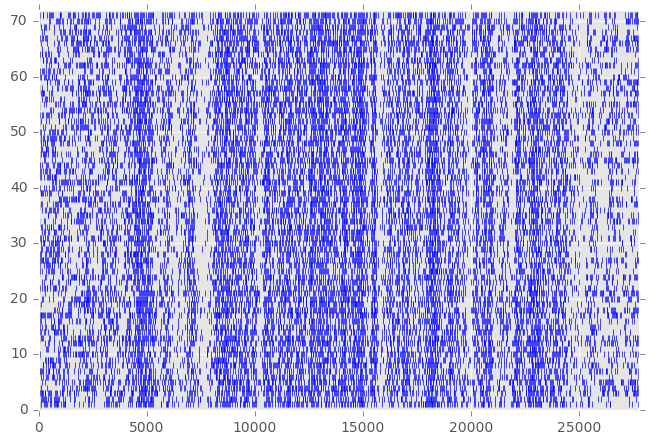

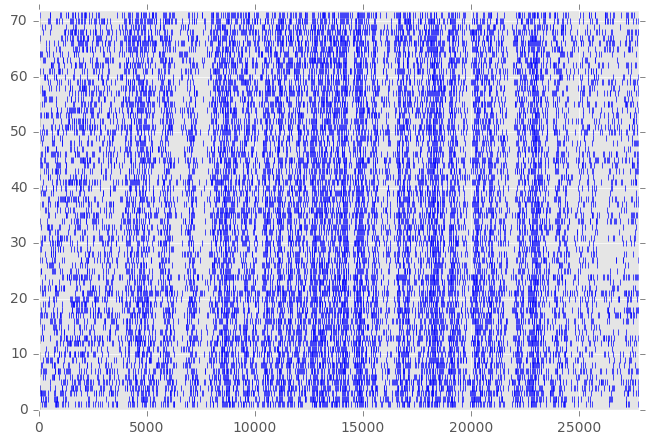

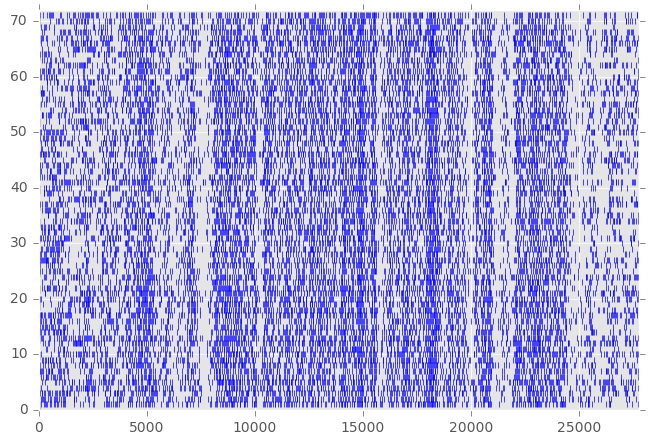

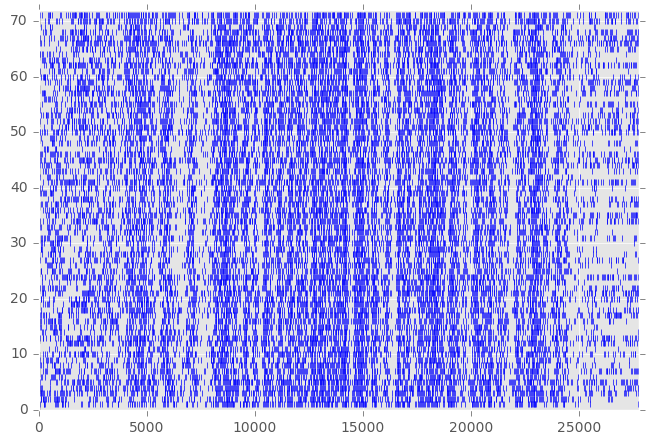

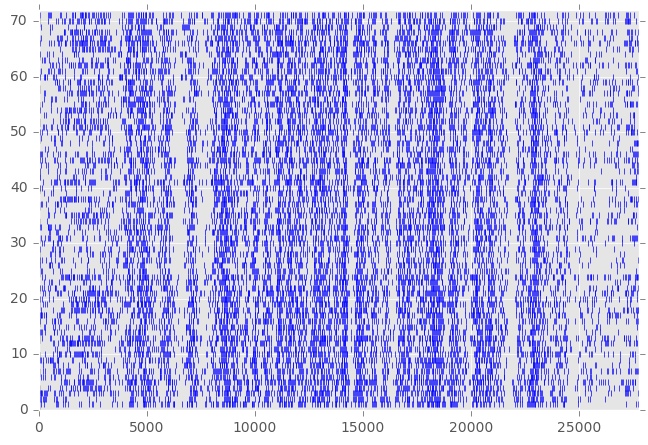

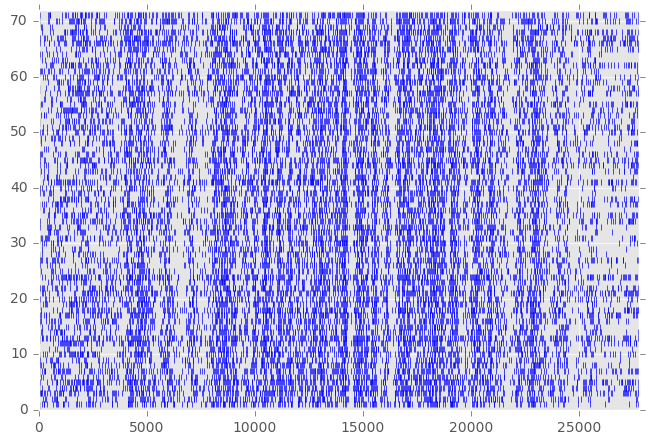

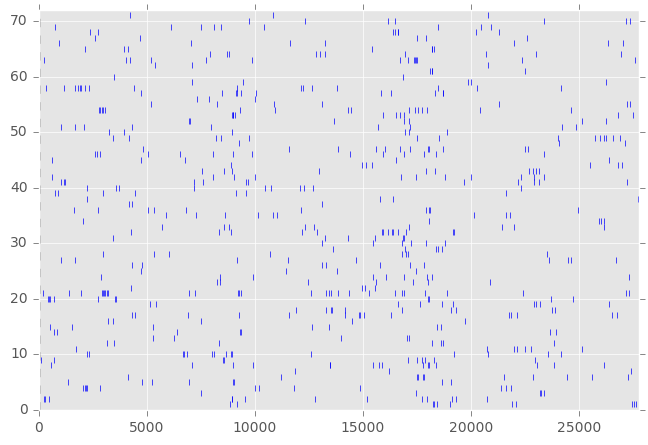

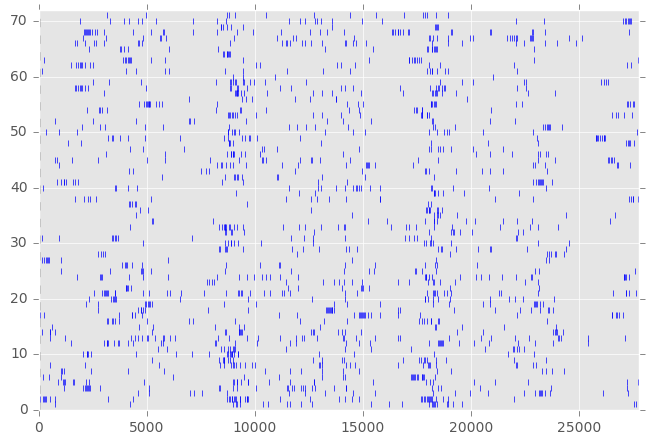

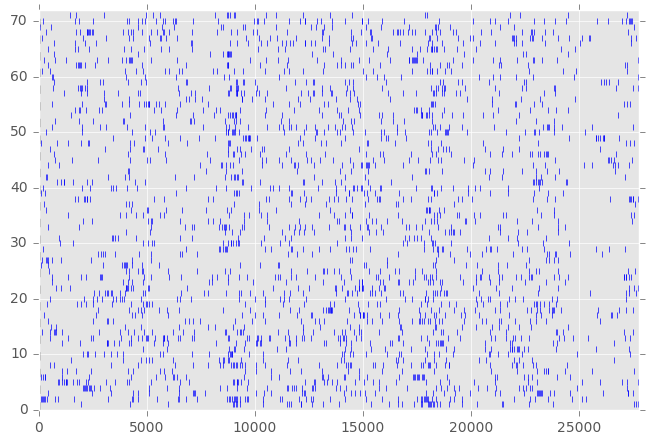

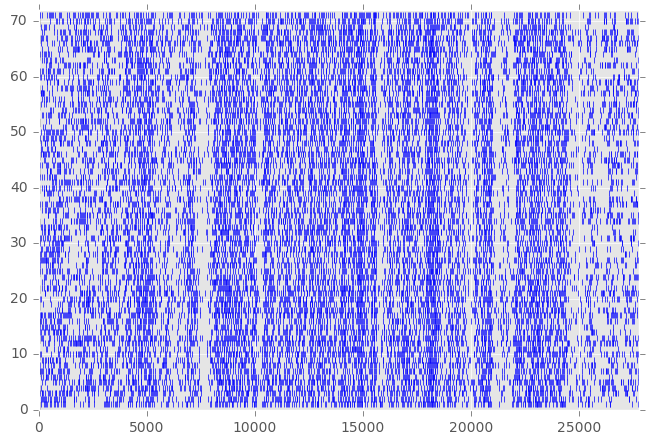

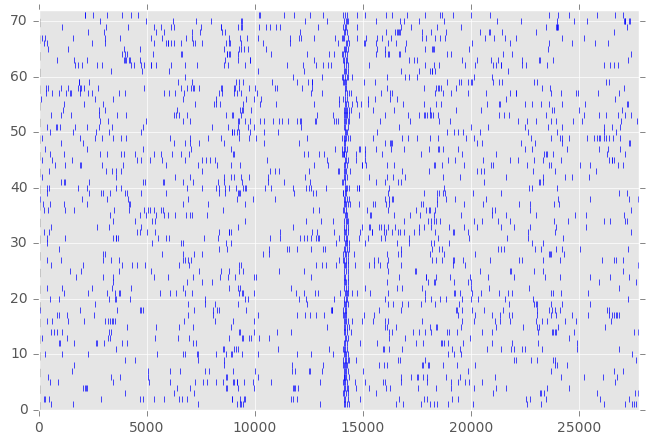

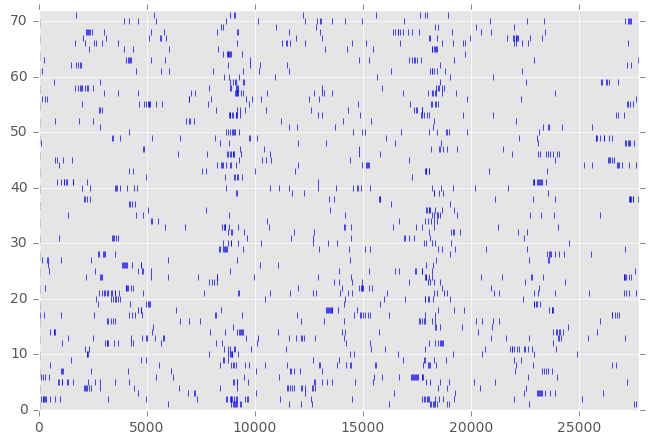

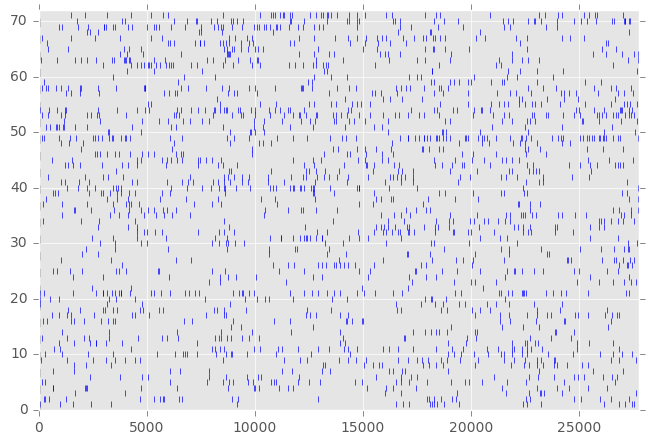

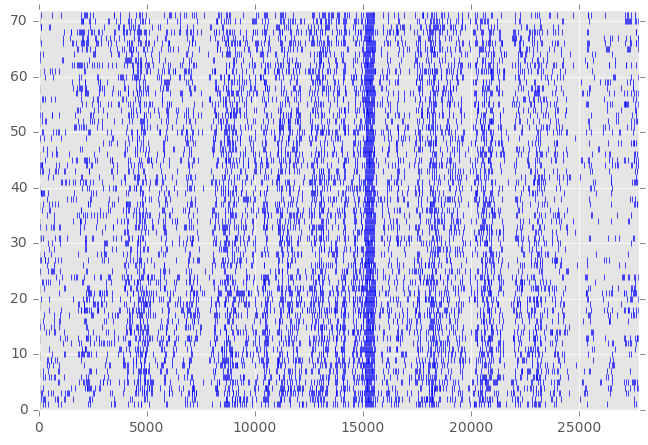

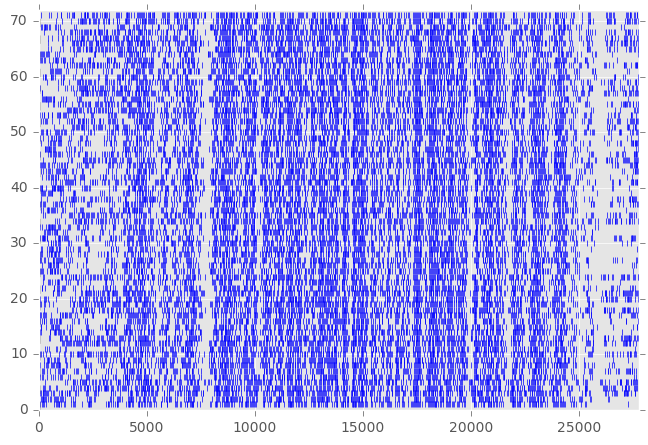

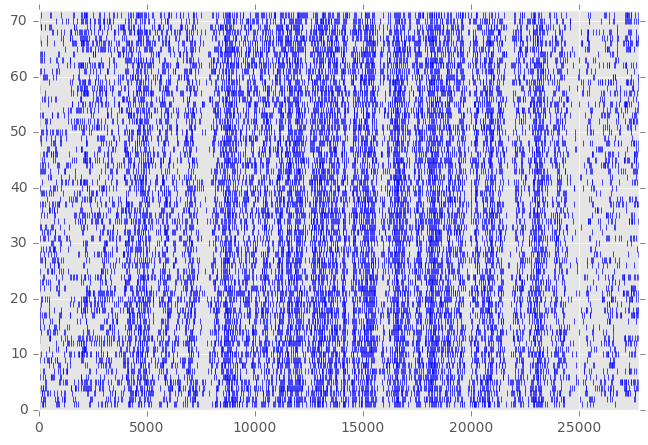

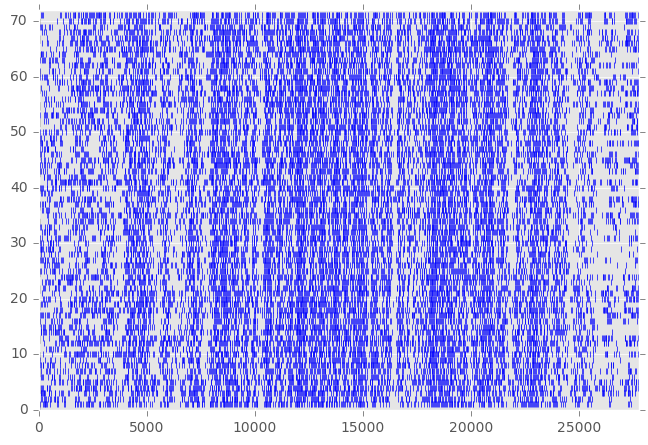

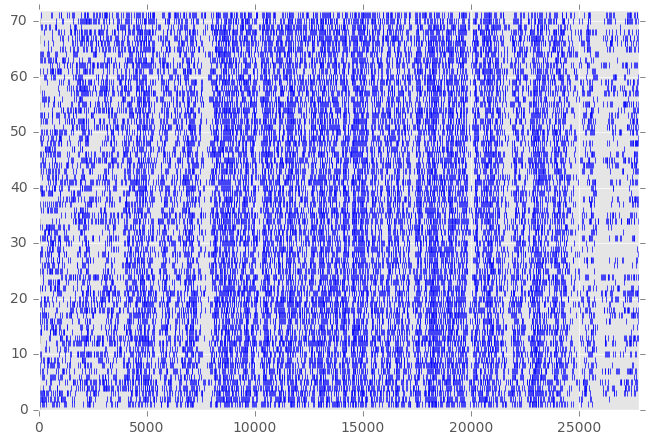

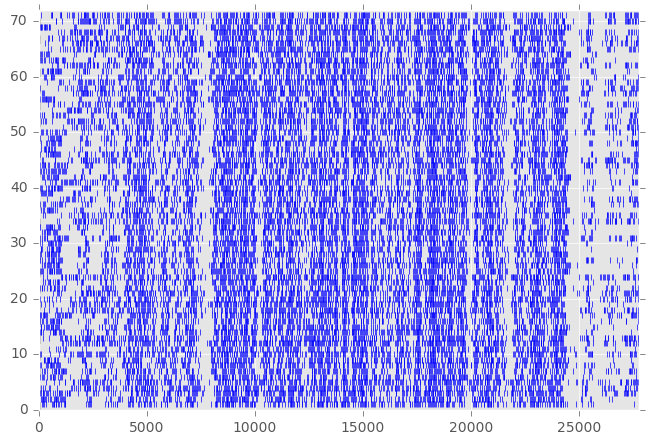

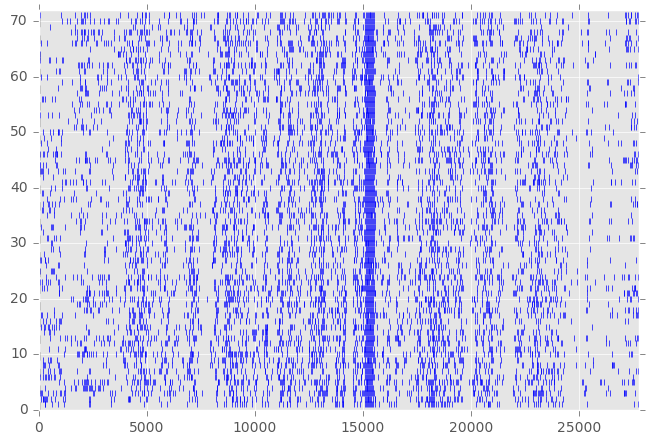

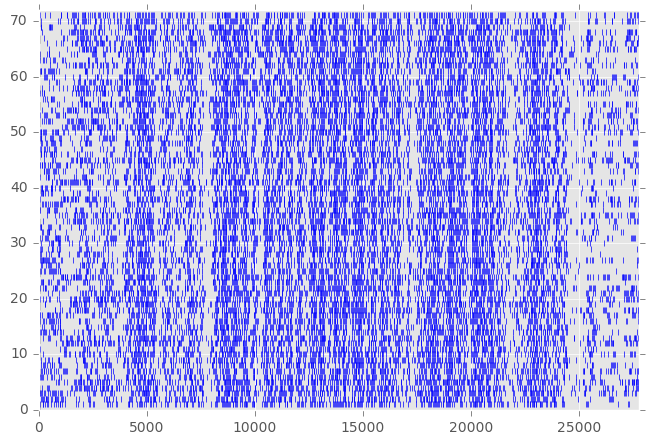

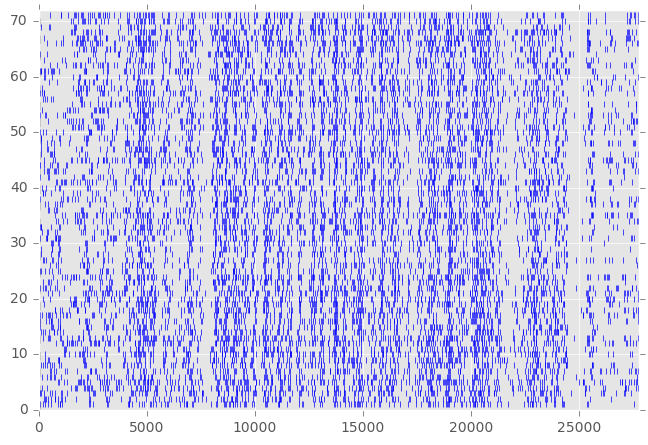

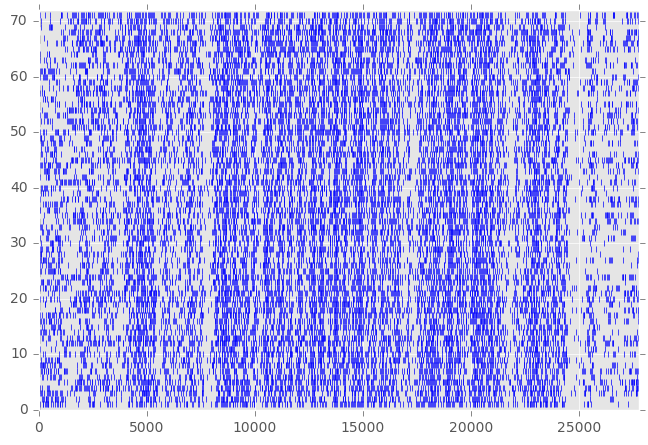

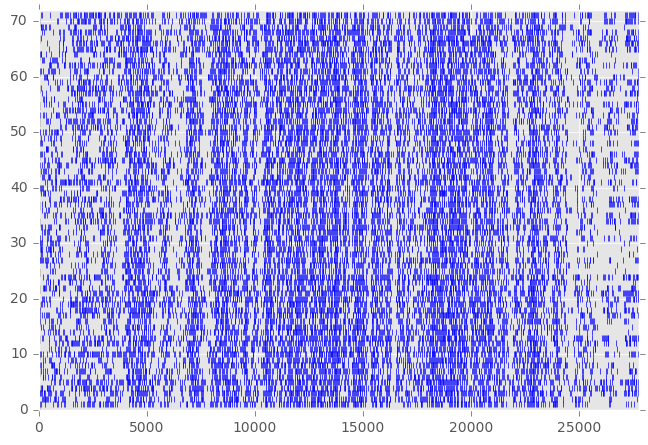

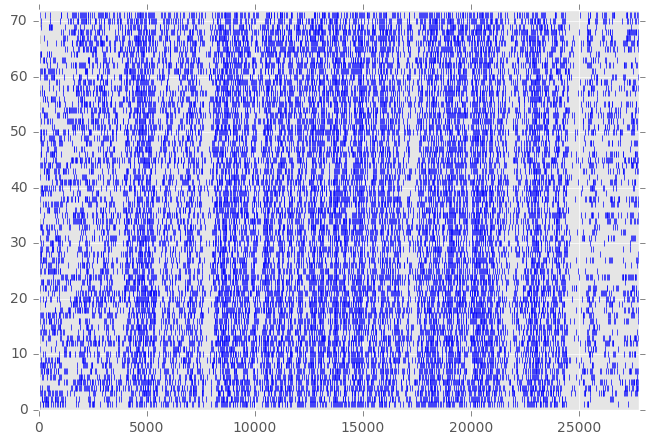

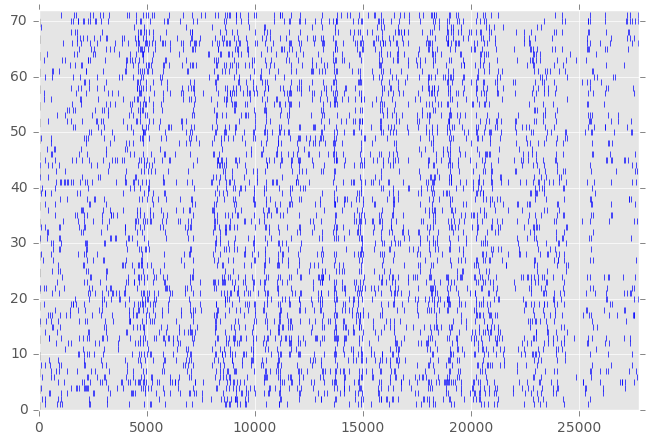

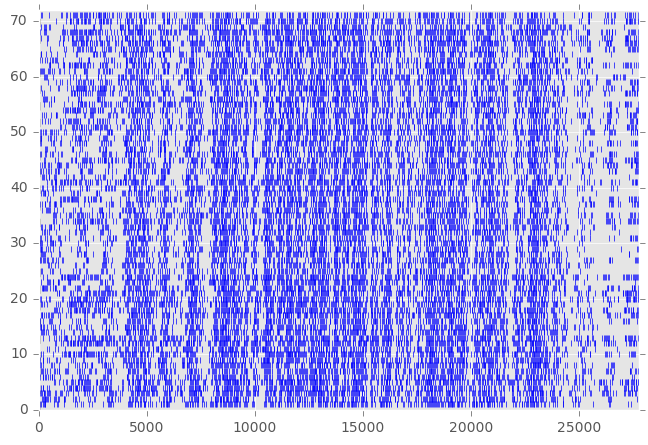

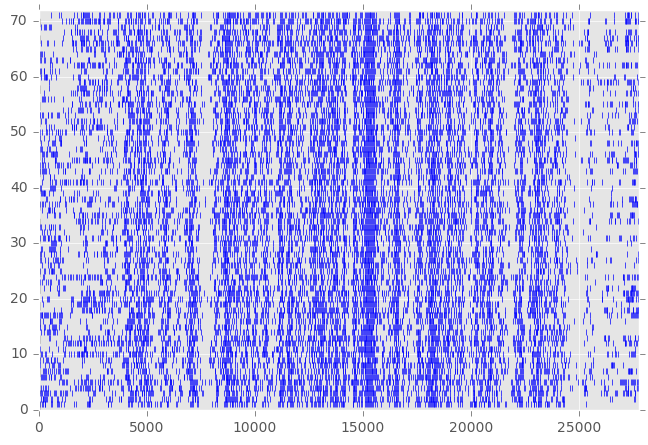

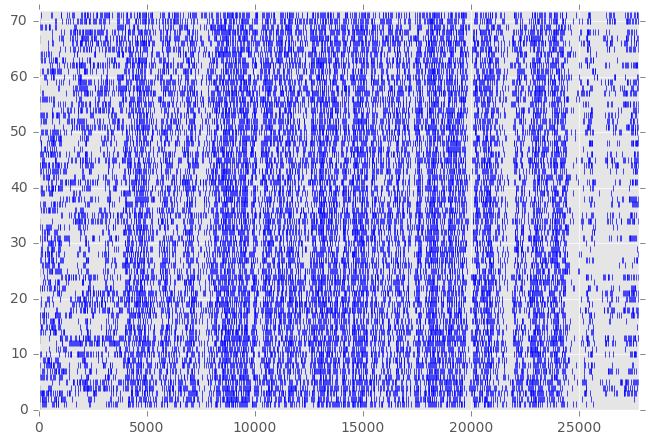

In [12]:
spike_thresh = 4.5
thresh = rms*spike_thresh
all_spk_arr = collect_all_spk_arr(all_frames, thresh, min_dist=20)
for i in range(neural_chans.size):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    bp.plot_raster(all_spk_arr[:,:,i])


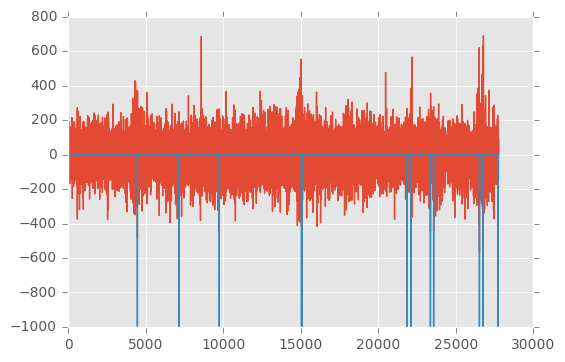

In [13]:
fr_n = 16
ch_n = 1
plt.plot(all_frames[fr_n].data[:, ch_n])
plt.plot(all_spk_arr[fr_n,:,ch_n]*(-1000));

In [14]:
starts

array([  1163019,   1089649,   1066718,   1140048,   1044059,    800016,
          776742,   1071350,    863317,    839863,   1095769,   1048085,
          753735,    425433,    329445,    255790,    232464,    402378,
          475115,    306252,    209595,   6556745,   6580171,   6533693,
       251220564, 251047935, 298815519, 261064431, 250983424, 408881367,
       250960123, 269879472,    702573, 270254686, 251197198, 269959700,
       269855887, 251024491, 298839264, 408792242, 186201666, 433160231,
       308791969, 408769005, 250937166, 270278000, 308815563, 260968317,
       433091787,    679131, 298792325, 269936195, 433068453, 433216105,
       269832823, 270301690, 408746044, 433136712, 261041137, 186225442,
          850097, 308768936, 333453510, 186249508, 408858147,    656046,
       260945130,    826825, 433240010, 333430373, 433045425])

In [15]:
def find_silent(sup_vec):
    silent_list = np.array([any(~(sup_vec[i,:,:].any(axis=0))) for i in range(sup_vec.shape[0])])
    return silent_list

def support_vector_from_raw(starts, recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=10, s_f=30000, history_bins=1, no_silent=True):

    print starts.shape
    bin_size_samples = int(bin_size * s_f / 1000.)
    len_bin = int(len_samples / bin_size_samples)
    len_ms = int(len_bin * bin_size)
    history_samples = history_bins * bin_size_samples
    span_ms = len_ms + bin_size * history_bins
    span_samples = int(span_ms * s_f / 1000.)

    # logger.info('span_ms = {}'.format(span_ms))
    # logger.info('{} units'.format(len(all_units)))

    all_frames = collect_frames(starts - history_samples,
                                span_samples,
                                s_f,
                                kwd_file,
                                recs,
                                channels)
    
    [fr.apply_filter(sp.apply_butter_bandpass, filter_pars) for fr in all_frames]
    all_spk_arr = collect_all_spk_arr(all_frames, thresholds)
    
    rst_sv = np.stack([bp.col_binned(all_spk_arr[t,:,:].T, bin_size_samples) for t in range(all_spk_arr.shape[0])], 
                      axis=2)
    
    if no_silent:
        good_chans = ~find_silent(rst_sv)
    else:
        good_chans = channels

    return rst_sv[good_chans, :, :]




In [16]:
gc_sv = sv[~filter_silent(sv), :,:]
for i in range(gc_sv.shape[0]):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    plt.plot(np.mean(gc_sv[i, :,:], axis=1))

NameError: name 'sv' is not defined

In [ ]:
# INTO THE WILD FITTING NOW
def transform_env(x):
    x[x<0] = 0
    return x

def transform_alpha(x):
    x[x<0.15] = 0
    x[x>=.15] = .3
    return x

def transform_beta(x):
    x[x<0] = 0
    return x

def mu_transform_beta(x):
    x[x<0] = 0
    return syn.np_mulog_inv(x, 256)


def linear_fit(channels, thresholds, kwd_file, trial_starts, trial_recs, par_stream, bin_size=10, history_bins=15, s_f=30000):
    bin_size_samples = int(bin_size*s_f/1000.)
    len_samples = par_stream.shape[0]
    model_pars = bp.col_binned(np.array([par_stream]), bin_size_samples)/bin_size_samples

        
    s_v = support_vector_from_raw(trial_starts, trial_recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=bin_size, s_f=s_f, history_bins=history_bins+1, no_silent=True)
    
    target = np.tile(model_pars, trial_starts.size).reshape(trial_starts.size, -1)
    logger.info('sv shape {0}, target shape {1}'.format(s_v.shape, target.shape))
    return ld.fit_kernel(s_v, target, history_bins+1)

def linear_predict(channels, thresholds, kwd_file, trial_starts, trial_recs, len_samples, kernel, 
                   bin_size=10, 
                   history_bins=15, 
                   s_f=30000,
                   no_silent=False):
    
    s_v = support_vector_from_raw(trial_starts, trial_recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=bin_size, s_f=s_f, history_bins=history_bins+1, no_silent=no_silent)
    
    logger.info('kernel shape {0}, sv_shape {1}, len_samples {2}'.format(kernel.shape, s_v.shape, len_samples))  
    return ld.kernel_predict(s_v, kernel)



In [ ]:
# Try a fit
fns = et.file_names(bird, '002')
all_aligned = np.load(os.path.join(fns['folders']['stim'], 'par_stream_aligned.npy'))
alpha = all_aligned[:, 0]
beta = all_aligned[:, 1]
env = all_aligned[:, 2]

In [ ]:
plt.plot(alpha)

In [36]:
starts[trials_train].shape


(71,)

In [91]:
s_v_new.shape

(28, 146, 71)

In [90]:
s_v.shape

(60, 146, 71)

2017-02-06 07:47:12,933 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:47:12,935 spike_detect_aux INFO     Creating support vector 32 chans, 71 trials
2017-02-06 07:47:12,937 spike_detect_aux INFO     Collecting 71 frames...
2017-02-06 07:47:12,938 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:47:13,565 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:47:13,945 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:47:14,539 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:47:15,025 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:47:15,548 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:47:15,795 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:47:16,496 spike_detect_aux INFO     Frame 70 ...
2017-02-06 07:47:22,123 spike_detect_aux INFO     sv shape (30, 87, 71), target shape (71, 60)
2017-02-06 07:47:22,232 spike_detect_aux INFO     k shape (841,)
2017-02-06 07:47:22,234 spike_detect_aux INFO     Convolving a kernel
2017-02-06 07:47:22,234 spike_de

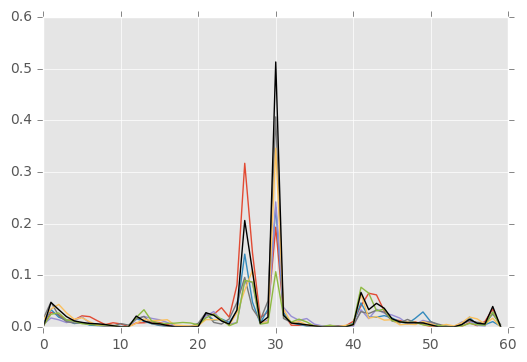

In [143]:
fitted_kernel, fitted_chans = aux.linear_fit(chans, thresh, kwd_file, starts[trials_train], recs[trials_train], par_stream, 
                       bin_size=b_s, history_bins=h_b)
#fitted_kernel.flatten()
par_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], par_stream.size, fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

plt.plot(syn.np_mulog_inv(aux.transform_beta(par_pred)).T);
plt.plot(syn.np_mulog_inv(bp.col_binned(par_stream.reshape(1, -1), b_s*30).T/(b_s*30)), 'k');

In [108]:
reload(aux)
from bci import synthetic as syn

par_stream = syn.np_mulog(beta)
from decoder import linear as ld
trials_train = np.arange(71)

bin_size = 5
history_bins = 10

chans = np.arange(thresh.size)

bin_size_samples = int(bin_size*s_f/1000.)
len_samples = par_stream.shape[0]
model_pars = bp.col_binned(np.array([par_stream]), bin_size_samples)/bin_size_samples

all_s_v = []
for thresh_factor in [5.5]:
    thresh = rms*thresh_factor
    s_v_new = support_vector_from_raw(starts, recs, len_samples, chans, thresh, kwd_file,
                            bin_size=bin_size, s_f=s_f, history_bins=history_bins+1, no_silent=True)
    all_s_v.append(s_v_new)

s_v = np.concatenate(all_s_v, axis=0)
target = np.tile(model_pars, starts.size).reshape(starts.size, -1)
logger.info('sv shape {0}, target shape {1}'.format(s_v.shape, target.shape))

2017-02-01 09:12:12,702 spike_detect_aux INFO     Computer: passaro
2017-02-01 09:12:12,708 root         INFO     Collecting 71 frames...
2017-02-01 09:12:12,710 root         INFO     Frame 0 ...
2017-02-01 09:12:12,782 root         INFO     Frame 10 ...
2017-02-01 09:12:12,837 root         INFO     Frame 20 ...
2017-02-01 09:12:12,883 root         INFO     Frame 30 ...


(71,)


2017-02-01 09:12:12,921 root         INFO     Frame 40 ...
2017-02-01 09:12:12,961 root         INFO     Frame 50 ...
2017-02-01 09:12:12,999 root         INFO     Frame 60 ...
2017-02-01 09:12:13,038 root         INFO     Frame 70 ...
2017-02-01 09:12:17,005 root         INFO     Collecting 71 frames...
2017-02-01 09:12:17,005 root         INFO     Frame 0 ...
2017-02-01 09:12:17,039 root         INFO     Frame 10 ...
2017-02-01 09:12:17,072 root         INFO     Frame 20 ...
2017-02-01 09:12:17,105 root         INFO     Frame 30 ...
2017-02-01 09:12:17,161 root         INFO     Frame 40 ...


(71,)


2017-02-01 09:12:17,208 root         INFO     Frame 50 ...
2017-02-01 09:12:17,250 root         INFO     Frame 60 ...
2017-02-01 09:12:17,291 root         INFO     Frame 70 ...
2017-02-01 09:12:20,914 root         INFO     sv shape (60, 141, 71), target shape (71, 131)


In [103]:
all_s_v.append(s_v_new)

In [44]:
target = np.tile(model_pars, starts.size).reshape(starts.size, -1)
target.shape

(71, 131)

In [171]:
from decoder import neural as nd
reload(nd)
X_train, Y_train, X_test, Y_test = nd.sup_to_keras(all_s_v, target, history_bins, n_test=10)

UnboundLocalError: local variable 'sup_correct' referenced before assignment

In [172]:
reload(nd)

<module 'decoder.neural' from '/mnt/cube/earneodo/repos/swissknife/decoder/neural.pyc'>

In [173]:
X_train, Y_train, X_test, Y_test = nd.sup_to_keras(all_s_v, target, history_bins, n_test=10)

UnboundLocalError: local variable 'sup_correct' referenced before assignment

In [119]:
X.shape

(9301, 280)

In [118]:
X=X[:,1:]

In [48]:
Y.shape

(9301,)

In [105]:
reload(ld)
X, Y = ld.data_arrange(s_v_new, target, history_bins)

norm_x = np.max(X)
norm_y = np.max(Y)
trial_len = s_v.shape[1] - history_bins

print X.shape
print Y.shape

2017-01-31 20:39:58,394 decoder.linear WARNING  Size mismatch between target and support vector


Size mismatch between target and support vector
(9301, 421)
(9301,)


In [121]:
reload(ld)
X, Y = ld.data_arrange(s_v, target, history_bins)
X = X[:, 1:]

norm_x = np.max(X)
norm_y = np.max(Y)
trial_len = s_v.shape[1] - history_bins

print X.shape
print Y.shape


from keras.models import Sequential
from keras.layers.core import Dense, Activation

n_feat = X.shape[1]
n_test = 10

X_train = X[:-(n_test*trial_len), :]
Y_train = Y[:-(n_test*trial_len)]
X_test = X[:(n_test*trial_len), :]
Y_test = Y[:(n_test*trial_len)]
logger.info('Train vector sizes {0} and {1}'.format(X_train.shape, Y_train.shape))
logger.info('Test vector sizes {0} and {1}'.format(X_test.shape, Y_test.shape))

model = Sequential()
model.add(Dense(40, input_dim=n_feat, init='uniform', activation='relu'))
model.add(Dense(1, init='normal'))
model.compile(loss='mean_absolute_error', optimizer='rmsprop')

model.fit(X_train, Y_train, nb_epoch=1000, batch_size=15, verbose=2, validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=10)

2017-02-01 19:46:41,098 decoder.linear WARNING  This function is deprecated, use the one in datashape.
2017-02-01 19:46:41,100 decoder.datashape WARNING  Size mismatch between target and support vector
2017-02-01 19:46:41,160 root         INFO     Train vector sizes (7991, 600) and (7991,)
2017-02-01 19:46:41,161 root         INFO     Test vector sizes (1310, 600) and (1310,)
2017-02-01 19:46:41,163 root         INFO     Train vector sizes (7991, 600) and (7991,)
2017-02-01 19:46:41,164 root         INFO     Test vector sizes (1310, 600) and (1310,)


(9301, 600)
(9301,)
Train on 7191 samples, validate on 800 samples
Epoch 1/1000
1s - loss: 0.1656 - val_loss: 0.1357
Epoch 2/1000
1s - loss: 0.1376 - val_loss: 0.1683
Epoch 3/1000
1s - loss: 0.1296 - val_loss: 0.1214
Epoch 4/1000
1s - loss: 0.1237 - val_loss: 0.1347
Epoch 5/1000
1s - loss: 0.1174 - val_loss: 0.1370
Epoch 6/1000
1s - loss: 0.1127 - val_loss: 0.1168
Epoch 7/1000
1s - loss: 0.1098 - val_loss: 0.1213
Epoch 8/1000
1s - loss: 0.1079 - val_loss: 0.1499
Epoch 9/1000
1s - loss: 0.1052 - val_loss: 0.1537
Epoch 10/1000
1s - loss: 0.1042 - val_loss: 0.1306
Epoch 11/1000
1s - loss: 0.1020 - val_loss: 0.1070
Epoch 12/1000
1s - loss: 0.1000 - val_loss: 0.1269
Epoch 13/1000
1s - loss: 0.0990 - val_loss: 0.1098
Epoch 14/1000
1s - loss: 0.0980 - val_loss: 0.1145
Epoch 15/1000
1s - loss: 0.0968 - val_loss: 0.1082
Epoch 16/1000
1s - loss: 0.0956 - val_loss: 0.1032
Epoch 17/1000
1s - loss: 0.0946 - val_loss: 0.1095
Epoch 18/1000
1s - loss: 0.0939 - val_loss: 0.1043
Epoch 19/1000
1s - loss:

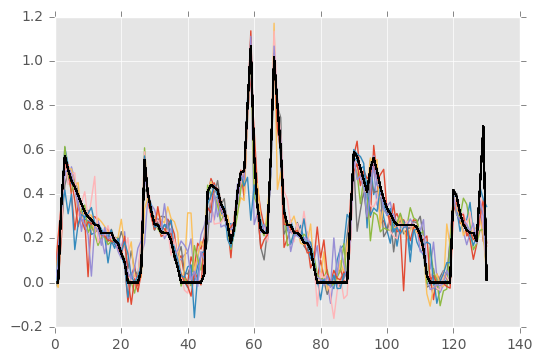

In [144]:
pred = model.predict(X_test, batch_size=15)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

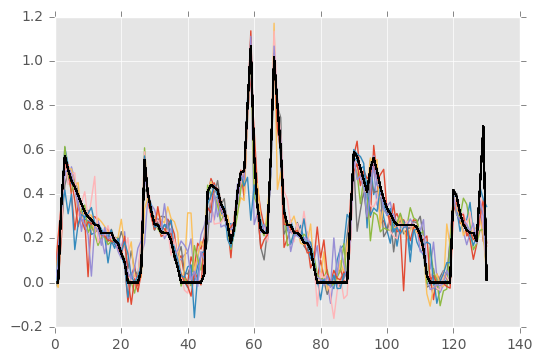

In [145]:
pred = model.predict(X_test, batch_size=15)
plt.plot((np.reshape(pred.flatten(), (10, -1)).T));
plt.plot((target.T), 'k');

2017-02-06 07:48:29,152 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:48:29,157 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:48:29,159 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:48:29,161 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:48:29,163 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:48:29,253 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:48:29,324 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:48:29,385 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:48:29,437 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:48:29,486 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:48:29,534 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:48:34,463 spike_detect_aux INFO     sv shape (30, 87, 65), target shape (65, 60)
2017-02-06 07:48:34,581 spike_detect_aux INFO     k shape (841,)
2017-02-06 07:48:34,582 spike_detect_aux INFO     Convolving a kernel
2017-02-06 07:48:34,583 spi

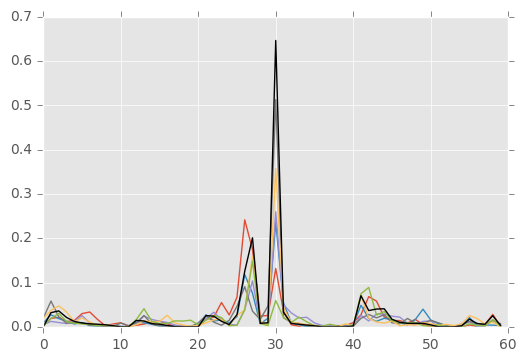

In [146]:
reload(aux)
from bci import synthetic as syn

par_stream = syn.np_mulog(beta)
from decoder import linear as ld
trials_train = np.arange(65)
trials_test = np.arange(65,71)
b_s = 11
h_b = 27
thresh_factor = 5.5
thresh = rms*thresh_factor
chans = np.arange(thresh.size)
fitted_kernel, fitted_chans = aux.linear_fit(chans, thresh, kwd_file, starts[trials_train], recs[trials_train], par_stream, 
                       bin_size=b_s, history_bins=h_b)
#fitted_kernel.flatten()
par_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], par_stream.size, fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

plt.plot(syn.np_mulog_inv(aux.transform_beta(par_pred)).T);
plt.plot(syn.np_mulog_inv(bp.col_binned(par_stream.reshape(1, -1), b_s*30).T/(b_s*30)), 'k');

In [147]:
nice_alpha = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

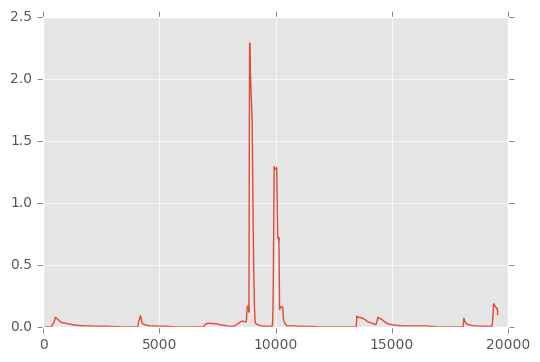

In [148]:
plt.plot(beta)

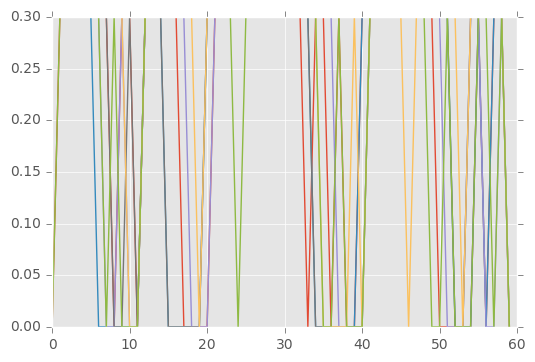

In [151]:
plt.plot(nice_alpha['streams'].T);

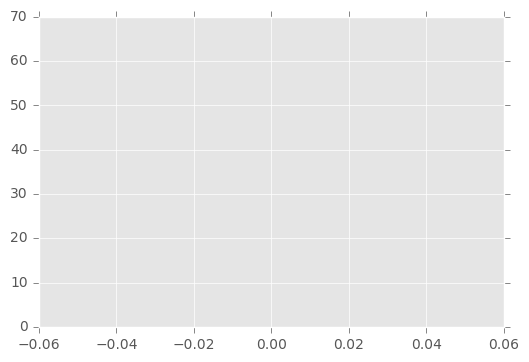

In [152]:
reload(bp)
#plt.plot(beta)
b_s = 10

plt.plot(bp.col_binned(beta.reshape(1, -1), 30));


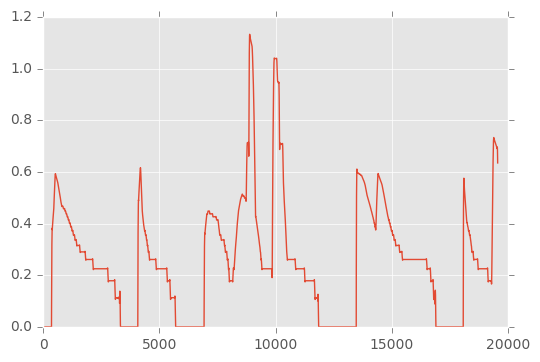

In [153]:
plt.plot(syn.np_mulog(beta))

In [154]:
nice_beta = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

In [155]:
reload(aux)
fit_result = aux.test_fit(chans, thresh, kwd_file, starts, recs, trials_train, trials_test, par_stream,
            bin_size=b_s,
            history_bins=h_b)

2017-02-06 07:49:28,977 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:49:28,979 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:49:28,981 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:49:28,983 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:49:28,984 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:49:29,067 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:49:29,135 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:49:29,212 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:49:29,286 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:49:29,350 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:49:29,405 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:49:34,074 spike_detect_aux INFO     sv shape (30, 93, 65), target shape (65, 66)
2017-02-06 07:49:34,206 spike_detect_aux INFO     k shape (841,)
2017-02-06 07:49:34,207 spike_detect_aux INFO     Convolving a kernel
2017-02-06 07:49:34,208 spi

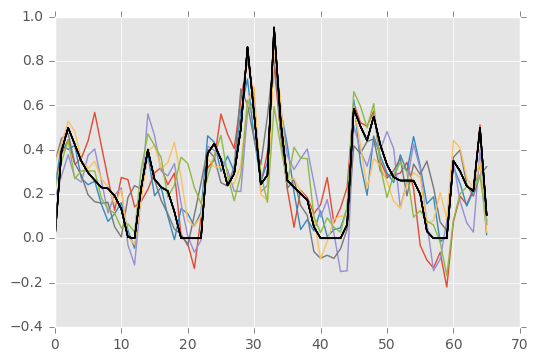

In [156]:
plt.plot(fit_result[1].T);
plt.plot(fit_result[3].T, 'k')

2017-02-06 07:50:05,814 spike_detect_aux INFO     Computer: passaro
2017-02-06 07:50:05,818 spike_detect_aux INFO     Testing for all pars with bin_size=11, history_size=29:
2017-02-06 07:50:05,819 spike_detect_aux INFO     Testing fit for a parameter
2017-02-06 07:50:05,821 spike_detect_aux INFO     Fitting a kernel
2017-02-06 07:50:05,823 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2017-02-06 07:50:05,824 spike_detect_aux INFO     Collecting 65 frames...
2017-02-06 07:50:05,826 spike_detect_aux INFO     Frame 0 ...
2017-02-06 07:50:05,913 spike_detect_aux INFO     Frame 10 ...
2017-02-06 07:50:05,981 spike_detect_aux INFO     Frame 20 ...
2017-02-06 07:50:06,042 spike_detect_aux INFO     Frame 30 ...
2017-02-06 07:50:06,113 spike_detect_aux INFO     Frame 40 ...
2017-02-06 07:50:06,164 spike_detect_aux INFO     Frame 50 ...
2017-02-06 07:50:06,254 spike_detect_aux INFO     Frame 60 ...
2017-02-06 07:50:11,321 spike_detect_aux INFO     sv shape (30, 89, 65), 

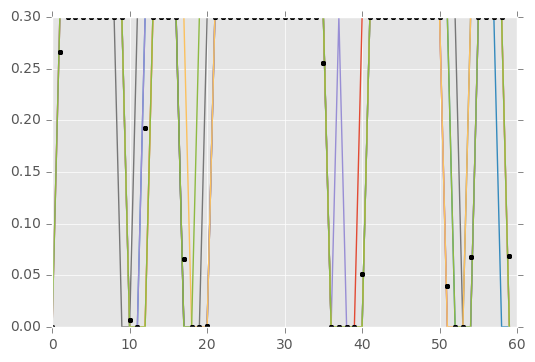

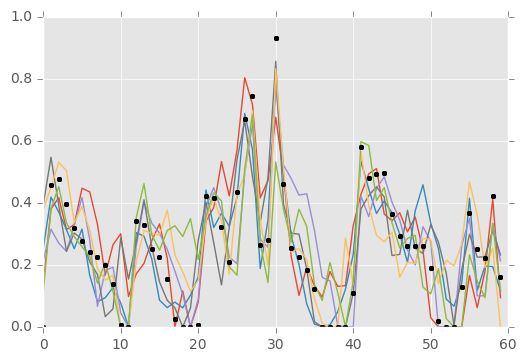

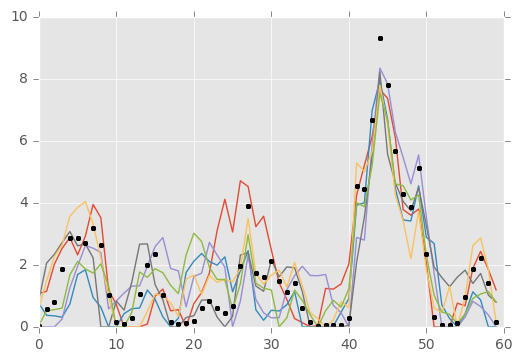

In [158]:
reload(aux)
b_s = 11
h_b = 29
thresh_factor = 5.5
thresh = rms*thresh_factor
all_result = aux.altogether_test(alpha, syn.np_mulog(beta), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k.')

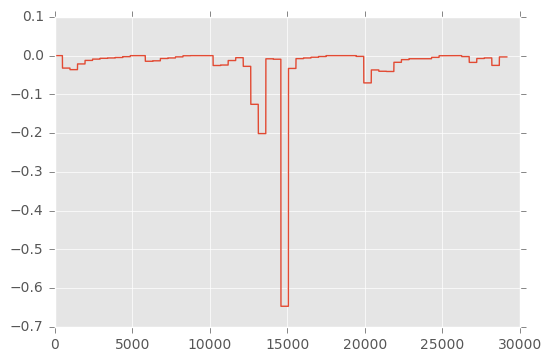

In [159]:
def resample_no_interp(x, s_f, new_s_f, axis=0):
    assert(new_s_f>=s_f)
    n_repeats = np.int(np.ceil(new_s_f/s_f))
    return np.repeat(x, n_repeats, axis=axis)

#now try to synthesise for this test
def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T

n_test = 5
fitted_streams = all_result[3][:,n_test,:]


abe_streams = latent_to_stream(fitted_streams[0, :], 
                               syn.np_mulog_inv(fitted_streams[1, :]), 
                               fitted_streams[2, :])

abe_streams_rs = resample_no_interp(abe_streams, 1000./b_s, 44100)
plt.plot(abe_streams_rs[:,1])

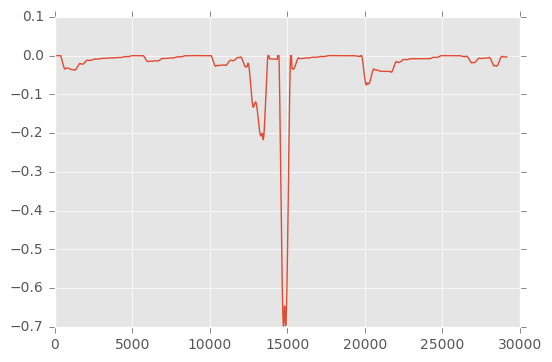

In [160]:
from scipy.signal import savgol_filter
abe_streams_rs[:,1] = savgol_filter(abe_streams_rs[:,1], 441, 3)
abe_streams_rs[abe_streams_rs[:,1] > 0, 1] = 0
# smooth_some
plt.plot(abe_streams_rs[:,1])

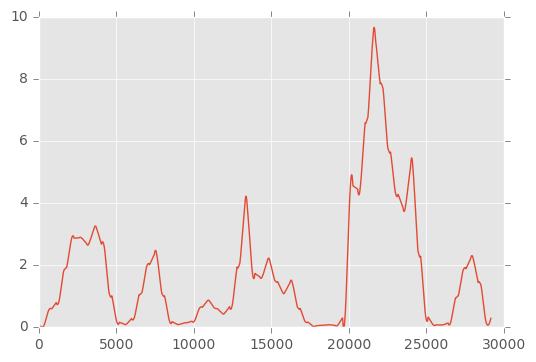

In [161]:
abe_streams_rs[:,2] = savgol_filter(abe_streams_rs[:,2], 661, 3)
abe_streams_rs[abe_streams_rs[:,2] < 0, 2] = 0
# smooth_some
plt.plot(abe_streams_rs[:,2])

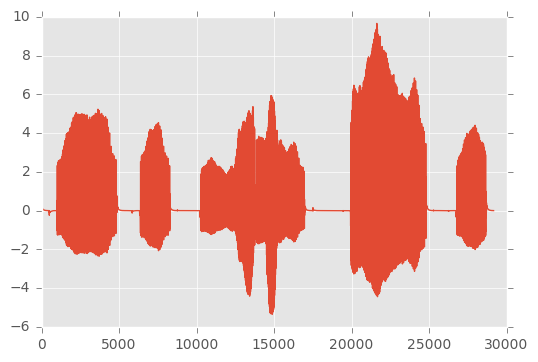

In [162]:
from dynamo import finch as zf
s_s = zf.make_song(abe_streams_rs)
plt.plot(s_s[:,0])

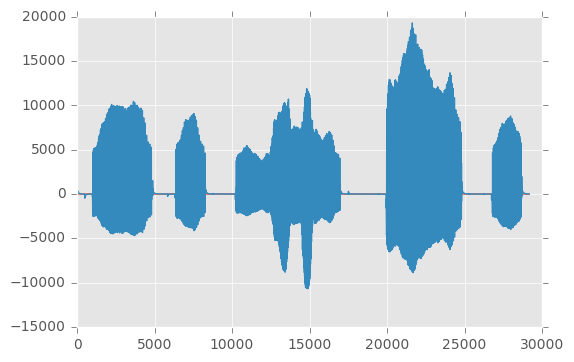

In [163]:
plt.plot(s_s[:, 0])
def wavify(x):
    return (x/np.ptp(x)*30000).astype(np.int16)

plt.plot(wavify(s_s[:, 0]))

wav_fn = os.path.join(et.file_names(bird, '002')['folders']['stim'], 'synth_thresh2.wav')
wavfile.write(wav_fn, 44100, wavify(s_s[:, 0]))


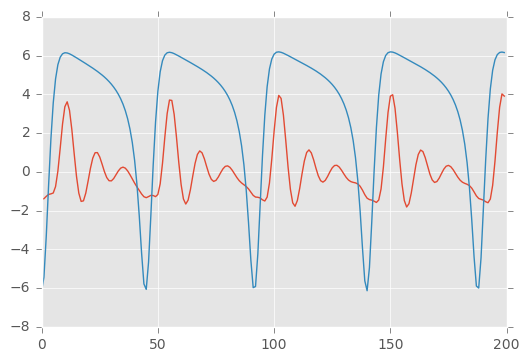

In [164]:
plt.plot(s_s[1500:1700, :])

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


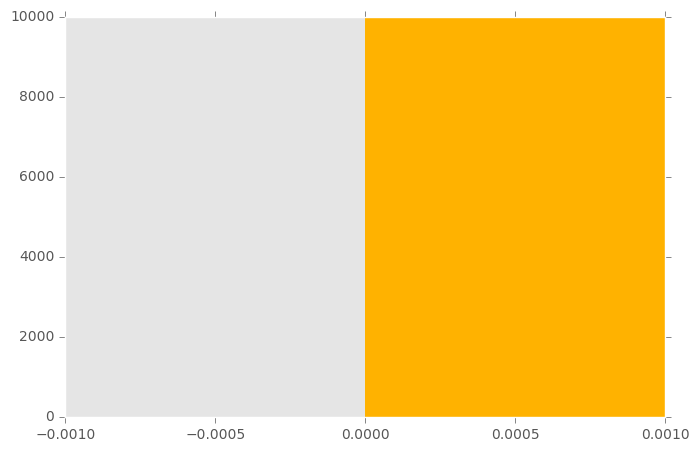

In [165]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

spectr_bos, ax = plot_spectrogram(s_s[:, 0], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

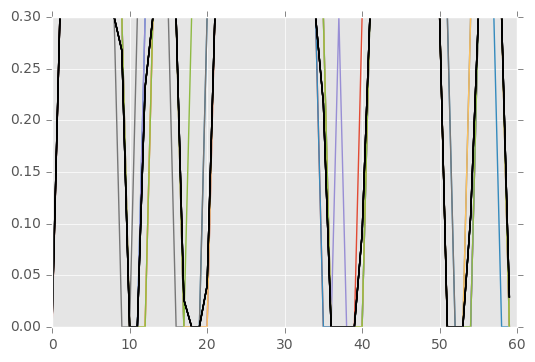

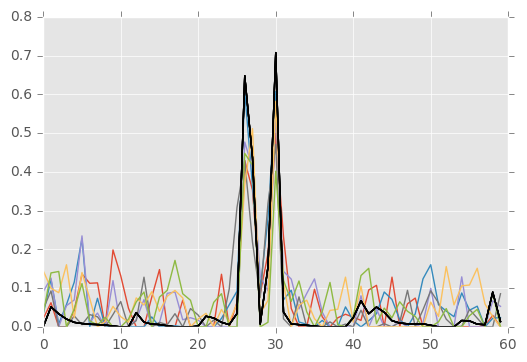

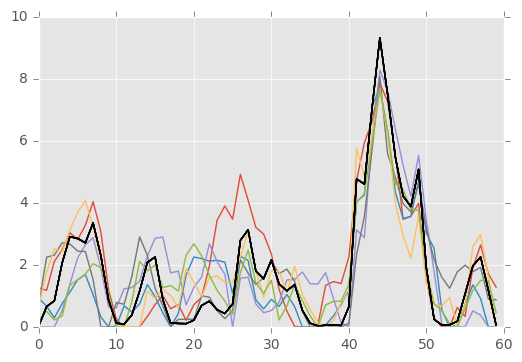

In [34]:
for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k')

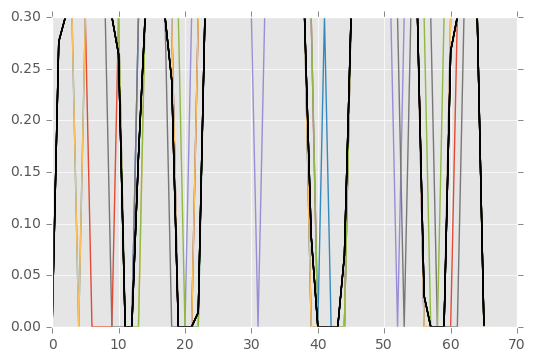

In [274]:
#plt.plot(all_result[1][0].T);
plt.plot(all_result[1][0].T);
plt.plot(all_result[3][0].T, 'k')

In [230]:
reload(aux)
env_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], env.size, 
                              fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

2016-12-13 10:39:17,631 spike_detect_aux INFO     Computer: passaro
2016-12-13 10:39:17,633 spike_detect_aux INFO     k shape (465,)
2016-12-13 10:39:17,635 spike_detect_aux INFO     Convolving a kernel
2016-12-13 10:39:17,636 spike_detect_aux INFO     Channels are 29
2016-12-13 10:39:17,638 spike_detect_aux INFO     Creating support vector 29 chans, 6 trials
2016-12-13 10:39:17,639 spike_detect_aux INFO     Collecting 6 frames...
2016-12-13 10:39:17,641 spike_detect_aux INFO     Frame 0 ...
2016-12-13 10:39:18,073 spike_detect_aux INFO     kernel shape (465,), sv_shape (29, 81, 6), len_samples 19503


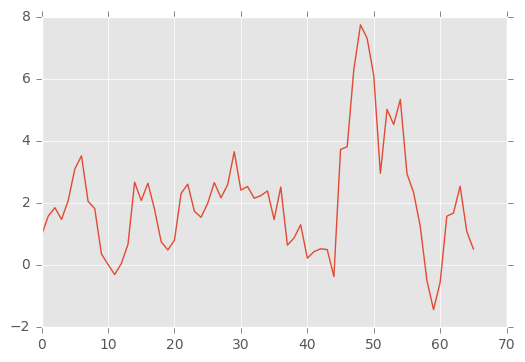

In [251]:
plt.plot(env_pred[1])

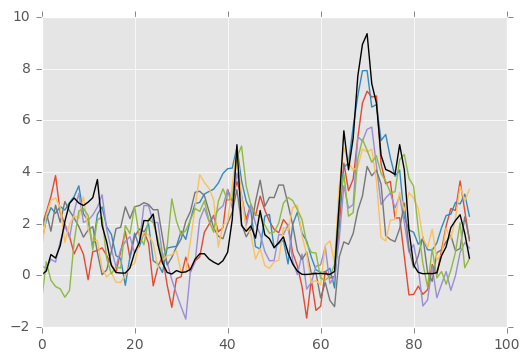

In [185]:
plt.plot(env_pred.T);
plt.plot(bp.col_binned(env.reshape(1, -1), b_s*30).T/(b_s*30), 'k');

In [178]:
all_result = aux.altogether_test(alpha, beta, env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

array([[ 0.11122297,  0.10719738,  0.10260112, ...,  2.7971164 ,
         2.64351626,  1.48117981]])

In [289]:
s_f

30000

In [293]:
bins = [5, 6, 7, 8, 9, 10, 12, 15]
histories = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 27]
tests_sweep = []
for bs in bins:
    bs_sweep = []
    for hs in histories:
        logger.info('Testing with bs={0}, hs={1}:'.format(bs, hs))
        ev_tst = aux.altogether_test(alpha, syn.np_mulog(beta, 256), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                             bin_size=bs, 
                             history_bins=hs, 
                             s_f=s_f, 
                             nl_alpha = aux.transform_alpha, 
                             nl_beta = aux.transform_beta, 
                             nl_env = aux.transform_env
                            )
        bs_sweep.append(ev_tst)
    tests_sweep.append(bs_sweep)

2016-12-13 13:03:18,698 root         INFO     Testing with bs=5, hs=5:
2016-12-13 13:03:18,702 spike_detect_aux INFO     Testing for all pars with bin_size=5, history_size=5:
2016-12-13 13:03:18,703 spike_detect_aux INFO     Testing fit for a parameter
2016-12-13 13:03:18,705 spike_detect_aux INFO     Fitting a kernel
2016-12-13 13:03:18,707 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-13 13:03:18,708 spike_detect_aux INFO     Collecting 65 frames...
2016-12-13 13:03:18,709 spike_detect_aux INFO     Frame 0 ...
2016-12-13 13:03:18,777 spike_detect_aux INFO     Frame 10 ...
2016-12-13 13:03:18,832 spike_detect_aux INFO     Frame 20 ...
2016-12-13 13:03:18,884 spike_detect_aux INFO     Frame 30 ...
2016-12-13 13:03:18,925 spike_detect_aux INFO     Frame 40 ...
2016-12-13 13:03:18,963 spike_detect_aux INFO     Frame 50 ...
2016-12-13 13:03:19,000 spike_detect_aux INFO     Frame 60 ...
2016-12-13 13:03:22,301 spike_detect_aux INFO     sv shape (32, 136, 65)

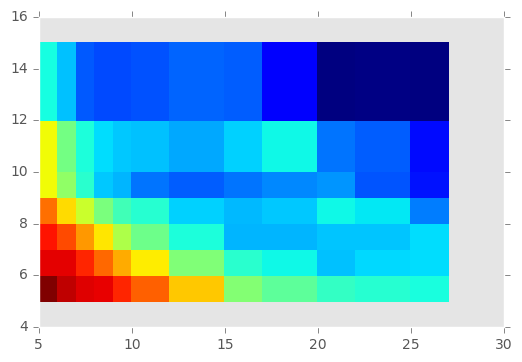

In [320]:
import itertools
n_bs = len(bins)
n_hs = len(histories)
k_par = 1

res_array = np.zeros([n_bs, n_hs, 3])
for b, h in itertools.product(range(n_bs), range(n_hs)):
    res_array[b, h, :] = tests_sweep[b][h][2]
plt.pcolormesh(histories, bins, res_array[:,:,k_par])

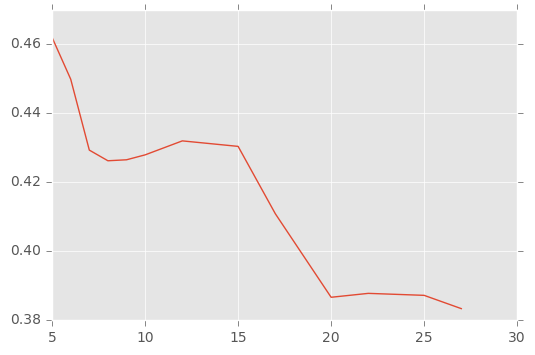

In [324]:
plt.plot(histories, res_array[6,:,k_par])

In [122]:
os.path.join('tuvieja', 'tar', '')

'tuvieja/tar/'

In [124]:
mode = 'w:'
ext = mode.split(':')[-1]

In [126]:
ext == ''

True

In [128]:
file_name = '{0}.tar'.format('tuvieja')

In [129]:
file_name+= '.{0}'.format(ext)

In [130]:
file_name

'tuvieja.tar.'